In [1]:
import os
import yaml
import pickle
import matplotlib
from multiprocessing import Pool
from typing import Dict, List, Tuple, Union
from numbers import Number

import torch
import numpy as np
import matplotlib.pyplot as plt
import bilby
import torch
import pandas as pd
import pycbc.psd
from scipy.signal import tukey
from pprint import pprint
from bilby.gw.conversion import (
    convert_to_lal_binary_black_hole_parameters,
    bilby_to_lalsimulation_spins,
)
from pprint import pprint
import lalinference.imrtgr.nrutils as nrutils
import lal
from gwpy.timeseries import TimeSeries
import scipy

import lalsimulation as LS


matplotlib.use('pdf')
os.environ['MPLCONFIGDIR'] = '/home/local/nihargupte'
import dingo.gw.dataset.generate_dataset 
from dingo.gw.inference import injection
import dingo.gw.training.train_builders
import dingo.gw.waveform_generator as waveform_generator
from dingo.gw.waveform_generator import wfg_utils
from dingo.gw.ASD_dataset.noise_dataset import ASDDataset
from dingo.gw.dataset import WaveformDataset
from dingo.gw.domains import build_domain, build_domain_from_model_metadata
import dingo.gw.inference
from dingo.gw.transforms import SelectStandardizeRepackageParameters, RepackageStrainsAndASDS, UnpackDict, SampleExtrinsicParameters, GNPECoalescenceTimes, AddWhiteNoiseComplex
from dingo.core.models import PosteriorModel
import dingo.gw.domains
from dingo.gw.waveform_generator import WaveformGenerator, sum_contributions_m
from dingo.gw.inference.gw_samplers import GWSamplerGNPE, GWSampler

%load_ext autoreload
%autoreload 2
%matplotlib inline

/data/nihargupte/projects/dingo-devel/tgr_venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
charizard_hex = ('#cd5241', '#084152', '#207394', '#eeb45a', '#e64110', '#ff524a', '#f6a410', '#08398b', '#626262', '#833118', '#eede7b')
meganium_hex = ("#62bd41", "#7b1039", "#624a00", "#f6a49c", "#e6ac00", "#ff395a", "#6a6a6a", "#107b31", )
wobbuffet_hex = ("#20528b", "#525252", "#ff8b00", "#a41000", "#de5200", "#62bd41")
plt.rcParams['text.usetex'] = False
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['font.size'] = 15
plt.rcParams['xtick.major.size'] = 5.0
plt.rcParams['xtick.minor.size'] = 3.0
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=charizard_hex)

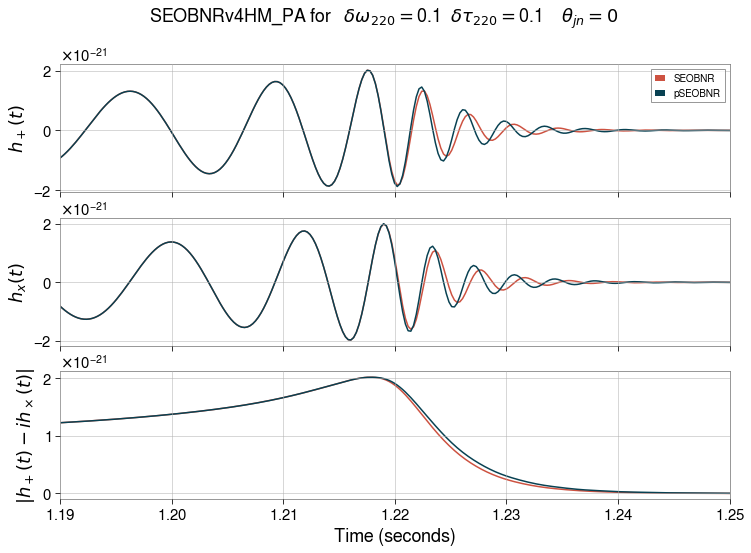

In [3]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=charizard_hex)
def _convert_to_scalar(x: Union[np.ndarray, float]) -> Number:
    """
    Convert a single element array to a number.

    Parameters
    ----------
    x:
        Array or number

    Returns
    -------
    A number
    """
    if isinstance(x, np.ndarray):
        if x.shape == () or x.shape == (1,):
            return x.item()
        else:
            raise ValueError(
                f"Expected an array of length one, but shape = {x.shape}"
            )
    else:
        return x

def convert_parameters_to_lal_frame(parameter_dict: Dict, approximant, domain_dict, lal_params=None) -> Tuple:
    """Convert to lal source frame parameters

    Parameters
    ----------
    parameter_dict : Dict
        A dictionary of parameter names and 1-dimensional prior distribution
        objects. If None, we use a default binary black hole prior.
    lal_params : (None, or Swig Object of type 'tagLALDict *')
        Extra parameters which can be passed to lalsimulation calls.

    Returns
    -------
    lal_parameter_tuple:
        A tuple of parameters for the lalsimulation waveform generator
    """
    # Transform mass, spin, and distance parameters
    p, _ = convert_to_lal_binary_black_hole_parameters(parameter_dict)

    # Convert to SI units
    p["mass_1"] *= lal.MSUN_SI
    p["mass_2"] *= lal.MSUN_SI
    p["luminosity_distance"] *= 1e6 * lal.PC_SI

    # Transform to lal source frame: iota and Cartesian spin components
    param_keys_in = (
        "theta_jn",
        "phi_jl",
        "tilt_1",
        "tilt_2",
        "phi_12",
        "a_1",
        "a_2",
        "mass_1",
        "mass_2",
        "f_ref",
        "phase",
    )
    param_values_in = [p[k] for k in param_keys_in]
    iota_and_cart_spins = bilby_to_lalsimulation_spins(*param_values_in)
    iota, s1x, s1y, s1z, s2x, s2y, s2z = [
        float(_convert_to_scalar(x)) for x in iota_and_cart_spins
    ]

    # Construct argument list for FD and TD lal waveform generator wrappers
    spins_cartesian = s1x, s1y, s1z, s2x, s2y, s2z
    masses = (p["mass_1"], p["mass_2"])
    extra_params = (p["luminosity_distance"], iota, p["phase"])
    ecc_params = (0.0, 0.0, 0.0)  # longAscNodes, eccentricity, meanPerAno

    if "delta_t" in domain_dict.keys():
        domain_pars = (domain_dict["delta_t"], domain_dict["f_min"], domain_dict["f_ref"])
    elif "delta_f" in domain_dict.keys():
        domain_pars = ((domain_dict["delta_f"], domain_dict["f_min"], domain_dict["f_max"], domain_dict["f_ref"]))

    lal_parameter_tuple = (
        masses
        + spins_cartesian
        + extra_params
        + ecc_params
        + domain_pars
        + (lal_params, approximant)
    )
    return lal_parameter_tuple

def setup_mode_array(mode_list: List) -> lal.Dict:
    """
    Define a LALSimulation "ModeArray" to select waveform modes
    to include in the polarizations from a list of modes.

    Parameters
    ----------
    mode_list : List
        a list of (ell, m) modes

    Returns
    -------
    lal_params : lal.Dict
    """
    lal_params = lal.CreateDict()
    ma = LS.SimInspiralCreateModeArray()
    for (ell, m) in mode_list:
        LS.SimInspiralModeArrayActivateMode(ma, ell, m)
    LS.SimInspiralWaveformParamsInsertModeArray(lal_params, ma)
    return lal_params

def SEOBNRv4HM_PA_TD(parameters, domain_dict, mode_array="*"):
    if mode_array == "*":
        lal_dict = lal.CreateDict()
    else:
        lal_dict = setup_mode_array(mode_array)

    approximant = LS.SEOBNRv4HM_PA
    LS.SimInspiralWaveformParamsInsertDOmega220(lal_dict, parameters["domega220"])
    LS.SimInspiralWaveformParamsInsertDTau220(lal_dict, parameters["dtau220"])
    parameters_lal = convert_parameters_to_lal_frame(parameters, approximant, domain_dict, lal_dict)
    hp, hc = LS.SimInspiralTD(*parameters_lal)
    h_plus = hp.data.data
    h_cross = hc.data.data
    return {"h_plus": h_plus, "h_cross": h_cross}

parameters = {
    "phase": 0.,
    "mass_1": 38.9, # Solar Masses
    "mass_2": 31.6, # Solar Masses
    "f_ref": 20., # Hz
    "phase": 0.,
    "chi_1": 0.,
    "chi_2": 0.,
    "theta_jn": 0,
    "luminosity_distance": 410., #Mpc
    "domega220": 0.,
    "dtau220": 0.
}

domain_dict = {
    "f_min": 20,
    "f_ref": 20,
    "f_max": 1024
}

time_duration = 8.0
sampling_rate = 2 * 2 * domain_dict["f_max"]
domain_dict["delta_t"] = 1 / sampling_rate

wf_dict_normal = SEOBNRv4HM_PA_TD(parameters, domain_dict, mode_array=[(2, 2), (2, 1), (3, 3), (4, 4), (5, 5)])
time_normal = 0 + np.arange(wf_dict_normal["h_plus"].shape[0]) * domain_dict["delta_t"]

parameters["domega220"] = 0.1
parameters["dtau220"] = 0.1

wf_dict_perturbed = SEOBNRv4HM_PA_TD(parameters, domain_dict, mode_array=[(2, 2), (2, 1), (3, 3), (4, 4), (5, 5)])
time_perturbed = 0 + np.arange(wf_dict_perturbed["h_plus"].shape[0]) * domain_dict["delta_t"]

wf_dicts = {"SEOBNR": {"waveform":wf_dict_normal, "time":time_normal}, "pSEOBNR": {"waveform":wf_dict_perturbed, "time":time_perturbed}}

fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
fig.suptitle(r"SEOBNRv4HM_PA for   $\delta \omega_{220} =$" + f"{parameters['domega220']}  " + r"$\delta \tau_{220} =$" + f"{parameters['dtau220']}    " + r"$\theta_{jn} = 0$")

for label, wf_dict in wf_dicts.items():
    wf = wf_dict["waveform"]
    time = wf_dict["time"]
    axes[0].plot(time, wf["h_plus"], label=label)
    strain_amplitude = np.sqrt(wf["h_plus"]**2 + wf["h_cross"]**2)
    axes[1].plot(time, wf["h_cross"], label=label)
    axes[2].plot(time, strain_amplitude, label=label)

axes[0].set_ylabel(r"$h_+(t)$")
axes[1].set_ylabel(r"$h_x(t)$")
axes[2].set_ylabel(r"$|h_+(t) - i h_\times(t)|$")
axes[0].legend()
plt.xlabel("Time (seconds)")
plt.xlim([1.19, 1.25])
plt.subplots_adjust(wspace=0, hspace=0.2)
# plt.savefig("/data/nihargupte/projects/dingo-devel/tutorials/06_tgr/plots/TD_1.pdf")

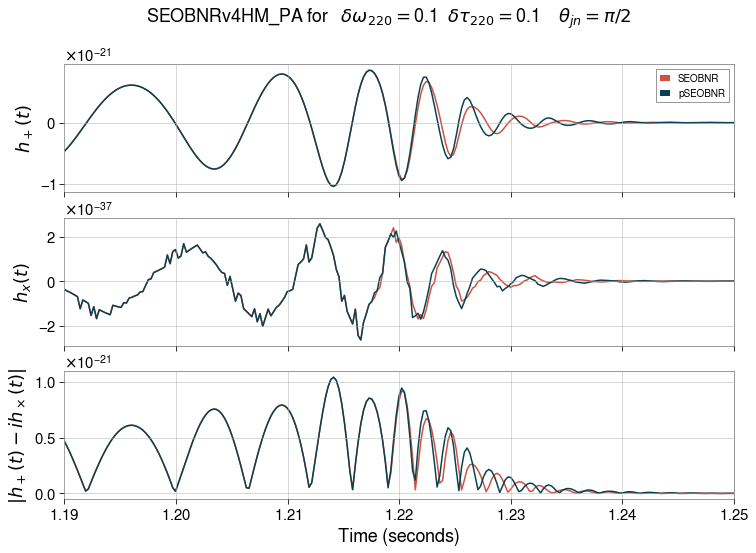

In [4]:
parameters = {
    "phase": 0.,
    "mass_1": 38.9, # Solar Masses
    "mass_2": 31.6, # Solar Masses
    "f_ref": 20., # Hz
    "phase": 0.,
    "chi_1": 0.,
    "chi_2": 0.,
    "theta_jn": np.pi / 2,
    "luminosity_distance": 410., #Mpc
    "domega220": 0.,
    "dtau220": 0.
}

wf_dict_normal = SEOBNRv4HM_PA_TD(parameters, domain_dict, mode_array=[(2, 2), (2, 1), (3, 3), (4, 4), (5, 5)])
time_normal = 0 + np.arange(wf_dict_normal["h_plus"].shape[0]) * domain_dict["delta_t"]

parameters["domega220"] = 0.1
parameters["dtau220"] = 0.1

wf_dict_perturbed = SEOBNRv4HM_PA_TD(parameters, domain_dict, mode_array=[(2, 2), (2, 1), (3, 3), (4, 4), (5, 5)])
time_perturbed = 0 + np.arange(wf_dict_perturbed["h_plus"].shape[0]) * domain_dict["delta_t"]

wf_dicts = {"SEOBNR": {"waveform":wf_dict_normal, "time":time_normal}, "pSEOBNR": {"waveform":wf_dict_perturbed, "time":time_perturbed}}

fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
fig.suptitle(r"SEOBNRv4HM_PA for   $\delta \omega_{220} =$" + f"{parameters['domega220']}  " + r"$\delta \tau_{220} =$" + f"{parameters['dtau220']}    " + r"$\theta_{jn} = \pi/2$")

for label, wf_dict in wf_dicts.items():
    wf = wf_dict["waveform"]
    time = wf_dict["time"]
    axes[0].plot(time, wf["h_plus"], label=label)
    strain_amplitude = np.sqrt(wf["h_plus"]**2 + wf["h_cross"]**2)
    axes[1].plot(time, wf["h_cross"], label=label)
    axes[2].plot(time, strain_amplitude, label=label)

axes[0].set_ylabel(r"$h_+(t)$")
axes[1].set_ylabel(r"$h_x(t)$")
axes[2].set_ylabel(r"$|h_+(t) - i h_\times(t)|$")
axes[0].legend()
plt.xlabel("Time (seconds)")
plt.xlim([1.19, 1.25])
plt.subplots_adjust(wspace=0, hspace=0.2)
# plt.savefig("/home/local/nihargupte/dingo-devel/tutorials/06_tgr/plots/TD_2.pdf")

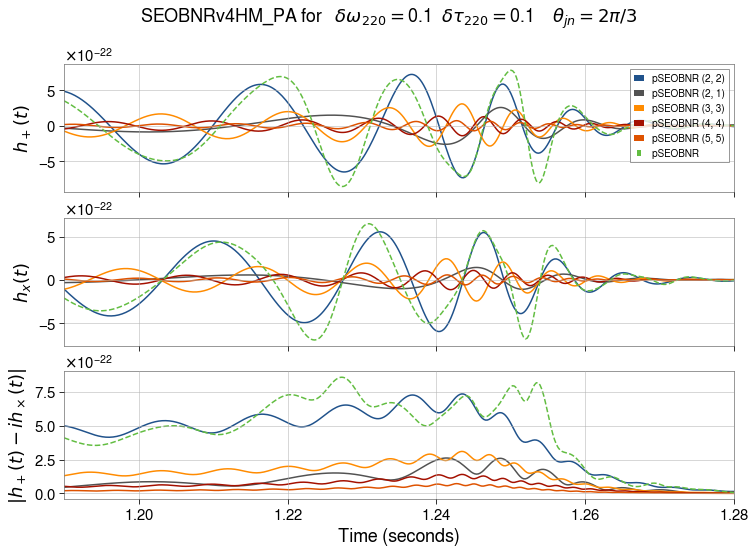

In [5]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=wobbuffet_hex)
parameters = {
    "phase": 0.,
    "chirp_mass": 30.0,
    "mass_ratio": 0.1,
    "f_ref": 20., # Hz
    "phase": 0.,
    "chi_1": 0.,
    "chi_2": 0.,
    "theta_jn": 2*np.pi/3,
    "luminosity_distance": 410., #Mpc
    "domega220": 0.1,
    "dtau220": 0.1
}

mode_list = [
    [(2, 2)],
    [(2, 1)],
    [(3, 3)],
    [(4, 4)],
    [(5, 5)],
]
mode_list.append([m[0] for m in mode_list])

fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
fig.suptitle(r"SEOBNRv4HM_PA for   $\delta \omega_{220} =$" + f"{parameters['domega220']}  " + r"$\delta \tau_{220} =$" + f"{parameters['dtau220']}    " + r"$\theta_{jn} = 2\pi/3$")

for modes in mode_list:
    wf = SEOBNRv4HM_PA_TD(parameters, domain_dict, mode_array=modes)
    time = 0 + np.arange(wf["h_plus"].shape[0]) * domain_dict["delta_t"]

    if len(modes) > 1:
        mode = ""
        linestyle="--"
    else:
        mode = modes[0]
        linestyle="-"
    label = f"pSEOBNR {mode}"
    axes[0].plot(time, wf["h_plus"], label=label, linestyle=linestyle)
    strain_amplitude = np.sqrt(wf["h_plus"]**2 + wf["h_cross"]**2)
    axes[1].plot(time, wf["h_cross"], label=label, linestyle=linestyle)
    axes[2].plot(time, strain_amplitude, label=label, linestyle=linestyle)

axes[0].set_ylabel(r"$h_+(t)$")
axes[1].set_ylabel(r"$h_x(t)$")
axes[2].set_ylabel(r"$|h_+(t) - i h_\times(t)|$")
axes[0].legend(loc="upper right")
plt.xlabel("Time (seconds)")
plt.xlim([1.19, 1.28])
plt.subplots_adjust(wspace=0, hspace=0.2)
# plt.savefig("/home/local/nihargupte/dingo-devel/tutorials/06_tgr/plots/TD_higher_modes_2.pdf")

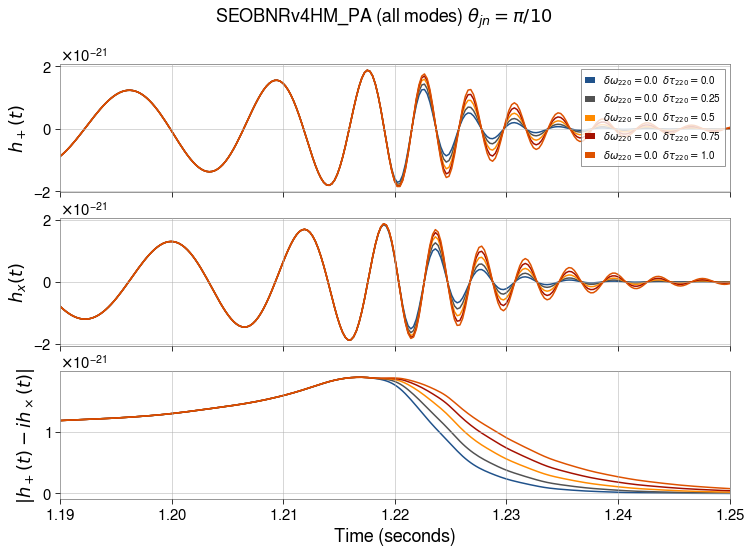

In [6]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=wobbuffet_hex)
parameters = {
    "phase": 0.,
    "mass_1": 38.9, # Solar Masses
    "mass_2": 31.6, # Solar Masses
    "f_ref": 20., # Hz
    "phase": 0.,
    "chi_1": 0.,
    "chi_2": 0.,
    "theta_jn": np.pi/10,
    "luminosity_distance": 410., #Mpc
    "domega220": 0.,
    "dtau220": 0.
}
n_deviations = 5
deviations = {"domega220":np.linspace(0, 0, n_deviations), "dtau220":np.linspace(0, 1, n_deviations)}


fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
fig.suptitle(r"SEOBNRv4HM_PA (all modes) " + r"$\theta_{jn} = \pi/10$")

for i in range(n_deviations):
    parameters["domega220"] = deviations["domega220"][i]
    parameters["dtau220"] = deviations["dtau220"][i]
    wf = SEOBNRv4HM_PA_TD(parameters, domain_dict, mode_array=[(2, 2), (2, 1), (3, 3), (4, 4), (5, 5)])
    time = 0 + np.arange(wf["h_plus"].shape[0]) * domain_dict["delta_t"]

    label = r"$\delta \omega_{220} =$" + f"{parameters['domega220']}  " + r"$\delta \tau_{220} =$" + f"{parameters['dtau220']}"
    axes[0].plot(time, wf["h_plus"], label=label)
    strain_amplitude = np.sqrt(wf["h_plus"]**2 + wf["h_cross"]**2)
    axes[1].plot(time, wf["h_cross"], label=label)
    axes[2].plot(time, strain_amplitude, label=label)

axes[0].set_ylabel(r"$h_+(t)$")
axes[1].set_ylabel(r"$h_x(t)$")
axes[2].set_ylabel(r"$|h_+(t) - i h_\times(t)|$")
axes[0].legend(loc="upper right")
plt.xlabel("Time (seconds)")
plt.xlim([1.19, 1.25])
plt.subplots_adjust(wspace=0, hspace=0.2)
# plt.savefig("/home/local/nihargupte/dingo-devel/tutorials/06_tgr/plots/TD_qnm_tau_deviations.pdf")

(1.0230658945071783e-22-2.5602580622745928e-23j) (1.0230658945071783e-22-2.5602580622745928e-23j)
(2.4017017126998055e-25-1.4735716929723606e-26j) (2.4017017126998055e-25-1.4735716929723606e-26j)
(7.830794497905268e-25-2.2158486320157467e-25j) (7.830794497905268e-25-2.2158486320157467e-25j)
(1.7225802136762264e-25+5.415649135255388e-28j) (1.7225802136762264e-25+5.415649135255388e-28j)
(3.0540015288042148e-27-1.0135237982416585e-28j) (3.0540015288042148e-27-1.0135237982416585e-28j)
0j 0j
(1.0249486163239569e-22-2.5739139694430155e-23j) (1.0249486163239569e-22-2.5739139694430155e-23j)


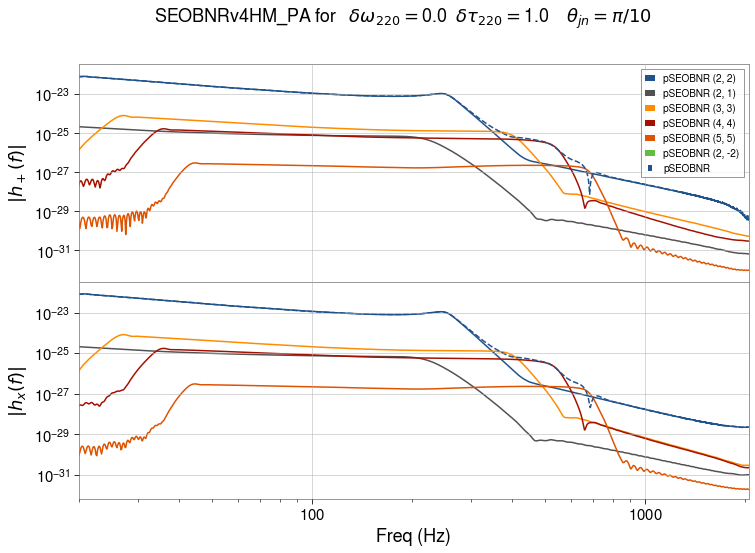

In [7]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=wobbuffet_hex)
def SEOBNRv4HM_PA_FD(parameters, domain_dict, mode_array="*"):
    if mode_array == "*":
        lal_dict = lal.CreateDict()
    else:
        lal_dict = setup_mode_array(mode_array)
    approximant = LS.SEOBNRv4HM_PA
    LS.SimInspiralWaveformParamsInsertDOmega220(lal_dict, parameters["domega220"])
    LS.SimInspiralWaveformParamsInsertDTau220(lal_dict, parameters["dtau220"])
    parameters_lal = convert_parameters_to_lal_frame(parameters, approximant, domain_dict, lal_dict)
    # hp, hc = LS.SimInspiralChooseFDWaveform(*parameters_lal)
    hp, hc = LS.SimInspiralFD(*parameters_lal)
    h_plus = hp.data.data
    h_cross = hc.data.data
    return {"h_plus": h_plus, "h_cross": h_cross}

domain_dict = {
    "delta_f": 0.125,
    "f_min": 20,
    "f_ref": 20,
    "f_max": 2048
}

mode_list = [
    [(2, 2)],
    [(2, 1)],
    [(3, 3)],
    [(4, 4)],
    [(5, 5)],
    [(2, -2)],
    "*"
]
# mode_list.append([m[0] for m in mode_list])

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
fig.suptitle(r"SEOBNRv4HM_PA for   $\delta \omega_{220} =$" + f"{parameters['domega220']}  " + r"$\delta \tau_{220} =$" + f"{parameters['dtau220']}    " + r"$\theta_{jn} = \pi/10$")

for modes in mode_list:
    wf = SEOBNRv4HM_PA_FD(parameters, domain_dict, modes)
    print(np.max(wf["h_plus"]), np.max(wf["h_plus"]))
    freq = 0 + np.arange(wf["h_plus"].shape[0]) * domain_dict["delta_f"]

    if modes == "*":
        label = "pSEOBNR"
        linestyle = "--"
    else:
        label = f"pSEOBNR {modes[0]}"
        linestyle = "-"
    axes[0].plot(freq, np.abs(wf["h_plus"]), label=label, linestyle=linestyle)
    axes[1].plot(freq, np.abs(wf["h_cross"]), label=label, linestyle=linestyle)

axes[0].set_yscale('log')
axes[1].set_yscale('log')
axes[0].set_ylabel(r"$|h_+(f)|$")
axes[1].set_ylabel(r"$|h_x(f)|$")
axes[0].legend()
plt.xlim([domain_dict["f_min"], domain_dict["f_max"]])
plt.xscale('log')
plt.xlabel("Freq (Hz)")
plt.subplots_adjust(wspace=0, hspace=0)
# plt.savefig("/home/local/nihargupte/dingo-devel/tutorials/06_tgr/plots/FD_HM.pdf")

2.442357144437534


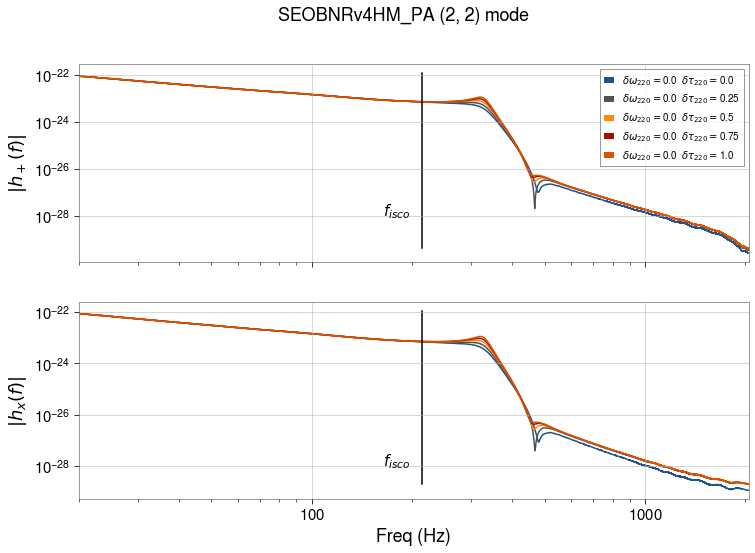

In [8]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=wobbuffet_hex)
parameters = {
    "phase": 0.,
    "mass_1": 38.9, # Solar Masses
    "mass_2": 30.9, # Solar Masses
    "f_ref": 20., # Hz
    "phase": 0.,
    "chi_1": 0.7,
    "chi_2": 0.7,
    "theta_jn": 0,
    "luminosity_distance": 440., #Mpc
    "domega220": 0.,
    "dtau220": 0.
}

n_deviations = 5
deviations = {"domega220":np.linspace(0, 0, n_deviations), "dtau220":np.linspace(0, 1, n_deviations)}

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
fig.suptitle(r"SEOBNRv4HM_PA (2, 2) mode")
for i in range(n_deviations):
    parameters["domega220"] = deviations["domega220"][i]
    parameters["dtau220"] = deviations["dtau220"][i]
    wf = SEOBNRv4HM_PA_FD(parameters, domain_dict, mode_array=[(2, 2)])
    freq = 0 + np.arange(wf["h_plus"].shape[0]) * domain_dict["delta_f"]

    label = r"$\delta \omega_{220} =$" + f"{parameters['domega220']}  " + r"$\delta \tau_{220} =$" + f"{parameters['dtau220']}"
    axes[0].plot(freq, np.abs(wf["h_plus"]), label=label)
    axes[1].plot(freq, np.abs(wf["h_cross"]), label=label)


m1, m2, chi1, chi2 = parameters["mass_1"], parameters["mass_2"], parameters["chi_1"], parameters["chi_2"]
chi_f = nrutils.bbh_final_spin_non_precessing_Healyetal(m1, m2, chi1, chi2, version="2016")
M = nrutils.bbh_final_mass_non_precessing_Healyetal(m1, m2, chi1, chi2, chif=chi_f, version="2016")
r_isco_tilde = nrutils.calc_isco_radius(chi_f)
print(r_isco_tilde)
omega_tilde = 1 / (r_isco_tilde**(3/2) + chi_f)
M_SI = M * lal.MSUN_SI
f_isco = omega_tilde / (np.pi * (M_SI*(lal.G_SI/(lal.C_SI**3))))

axes[0].text(f_isco - 50, 1e-28, r"$f_{isco}$")
axes[0].plot([f_isco, f_isco], [np.min(np.abs(wf["h_plus"])), np.max(np.abs(wf["h_plus"]))], c='k')
axes[1].text(f_isco - 50, 1e-28, r"$f_{isco}$")
axes[1].plot([f_isco, f_isco], [np.min(np.abs(wf["h_cross"])), np.max(np.abs(wf["h_cross"]))], c='k')

axes[0].set_xlim([domain_dict["f_min"], domain_dict["f_max"]])
axes[0].set_yscale('log')
axes[1].set_yscale('log')
axes[0].set_ylabel(r"$|h_+(f)|$")
axes[1].set_ylabel(r"$|h_x(f)|$")
axes[0].legend()
axes[0].legend(loc="upper right")
plt.xscale("log")
plt.xlabel("Freq (Hz)")
plt.subplots_adjust(wspace=0, hspace=0.2)
# plt.savefig("/home/local/nihargupte/dingo-devel/tutorials/06_tgr/plots/FD_omega.pdf")

2.442357144437534


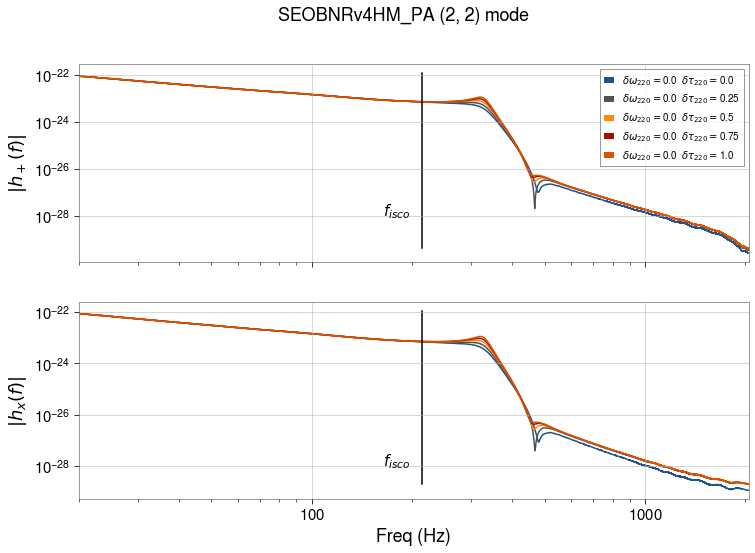

In [9]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=wobbuffet_hex)
parameters = {
    "phase": 0.,
    "mass_1": 38.9, # Solar Masses
    "mass_2": 30.9, # Solar Masses
    "f_ref": 20., # Hz
    "phase": 0.,
    "chi_1": 0.7,
    "chi_2": 0.7,
    "theta_jn": 0,
    "luminosity_distance": 440., #Mpc
    "domega220": 0.,
    "dtau220": 0.5
}

n_deviations = 5
deviations = {"domega220":np.linspace(0, 0, n_deviations), "dtau220":np.linspace(0, 1, n_deviations)}

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
fig.suptitle(r"SEOBNRv4HM_PA (2, 2) mode")
for i in range(n_deviations):
    parameters["domega220"] = deviations["domega220"][i]
    parameters["dtau220"] = deviations["dtau220"][i]
    wf = SEOBNRv4HM_PA_FD(parameters, domain_dict, mode_array=[(2, 2)])
    freq = 0 + np.arange(wf["h_plus"].shape[0]) * domain_dict["delta_f"]

    label = r"$\delta \omega_{220} =$" + f"{parameters['domega220']}  " + r"$\delta \tau_{220} =$" + f"{parameters['dtau220']}"
    axes[0].plot(freq, np.abs(wf["h_plus"]), label=label)
    axes[1].plot(freq, np.abs(wf["h_cross"]), label=label)


m1, m2, chi1, chi2 = parameters["mass_1"], parameters["mass_2"], parameters["chi_1"], parameters["chi_2"]
chi_f = nrutils.bbh_final_spin_non_precessing_Healyetal(m1, m2, chi1, chi2, version="2016")
M = nrutils.bbh_final_mass_non_precessing_Healyetal(m1, m2, chi1, chi2, chif=chi_f, version="2016")
r_isco_tilde = nrutils.calc_isco_radius(chi_f)
print(r_isco_tilde)
omega_tilde = 1 / (r_isco_tilde**(3/2) + chi_f)
M_SI = M * lal.MSUN_SI
f_isco = omega_tilde / (np.pi * (M_SI*(lal.G_SI/(lal.C_SI**3))))

axes[0].text(f_isco - 50, 1e-28, r"$f_{isco}$")
axes[0].plot([f_isco, f_isco], [np.min(np.abs(wf["h_plus"])), np.max(np.abs(wf["h_plus"]))], c='k')
axes[1].text(f_isco - 50, 1e-28, r"$f_{isco}$")
axes[1].plot([f_isco, f_isco], [np.min(np.abs(wf["h_cross"])), np.max(np.abs(wf["h_cross"]))], c='k')

axes[0].set_xlim([domain_dict["f_min"], domain_dict["f_max"]])
axes[0].set_yscale('log')
axes[1].set_yscale('log')
axes[0].set_ylabel(r"$|h_+(f)|$")
axes[1].set_ylabel(r"$|h_x(f)|$")
axes[0].legend()
axes[0].legend(loc="upper right")
plt.xscale("log")
plt.xlabel("Freq (Hz)")
plt.subplots_adjust(wspace=0, hspace=0.2)
# plt.savefig("/home/local/nihargupte/dingo-devel/tutorials/06_tgr/plots/FD_omega.pdf")

Ensuring Dingo WF Generation Works as Intended
----------------------------------------------

Setting spin_conversion_phase = 0.0. Using this value for the phase parameter for conversion to cartesian spins.


/data/nihargupte/projects/dingo-devel/tgr_venv/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


NameError: name 'times' is not defined

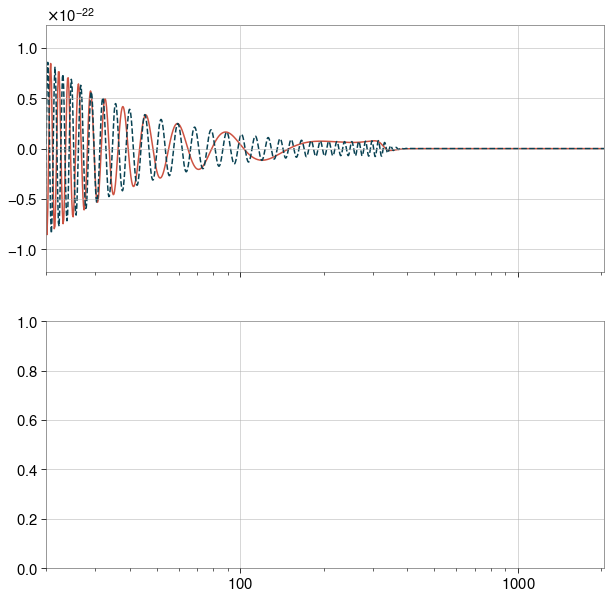

In [10]:
# NOTE IT WORKS BUT YOU HAVE TO CORRECT FOR THE `Undo the time shift done in SimInspiralFD to the waveform` in dingo.gw.waveform_generator.waveform_generator

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=charizard_hex)

domain_dict = {
    "type": "FrequencyDomain",
    "f_min": 20.0,
    "f_max": 2048.0,
    "delta_f": 0.125,
}
domain = build_domain(domain_dict)
domain_dict["f_ref"] = 20.0
wfg = WaveformGenerator(
    "SEOBNRv4HM_PA",
    domain,
    domain_dict["f_ref"],
    spin_conversion_phase=0.0,
)


parameters["dtau220"] = 0.5
wf_polarizations = wfg.generate_hplus_hcross(parameters)
wf_ref = SEOBNRv4HM_PA_FD(parameters, domain_dict)


fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
axes[0].set_xscale('log')
axes[0].set_xlim([20, 2048])
axes[0].plot(domain.sample_frequencies, wf_polarizations["h_plus"], label="WF generator WF")
axes[0].plot(domain.sample_frequencies, wf_ref["h_plus"], label="Correct WF", linestyle='--')
axes[1].plot(times, wf_polarizations["h_cross"], label="WF generator WF")
axes[1].plot(times, wf_ref["h_cross"], label="Correct WF", linestyle='--')
axes[0].legend()

Testing Dingo Waveform Dataset Works Properly
---------------------------------------------

In [ ]:
from dingo.gw.dataset import generate_dataset
with open("/data/nihargupte/projects/dingo-devel/tutorials/06_tgr/datasets/waveforms/settings_SEOBNRv4HM_PA.yaml", "r") as f:
    settings = yaml.safe_load(f)

# NOTE make sure to make some changes to this before running in particular no compression and decrease n_samples to 500
# dataset = generate_dataset(settings, num_processes=16)

# ref = wfg.generate_hplus_hcross(dataset[0]["parameters"])
# plt.xscale('log')
# plt.xlim([20, 2048])
# plt.plot(domain.sample_frequencies, dataset[0]["waveform"]["h_plus"], linestyle='--')
# plt.plot(domain.sample_frequencies, ref["h_plus"])

Testing DINGO Mode Sum for Synthetic Phase
------------------------------------------

In [ ]:
# Set theta_jn = 0 to get rid of all higher modes
parameters = {
    "phase": 4.7,
    "mass_1": 38.9, # Solar Masses
    "mass_2": 31.9, # Solar Masses
    "f_ref": 20., # Hz
    "phase": 0.,
    "chi_1": 0.2,
    "chi_2": 0.2,
    "theta_jn": 0.3,
    "luminosity_distance": 440., #Mpc
    "domega220": 0.,
    "dtau220": 0
}
domain_dict = {
    "type": "FrequencyDomain",
    "f_min": 20.0,
    "f_max": 2048.0,
    "delta_f": 0.125,
}
domain = build_domain(domain_dict)

In [ ]:
# For SEOBNRv4PHM
# Getting the WF through SimInspiralChooseTDWaveform
lal_params = waveform_generator.waveform_generator.SEOBNRv4HM_qnm_lal_dict(parameters)
p = wfg._convert_parameters_to_lal_frame(parameters, lal_params, lal_target_function="SimInspiralTD")
delta_t = p[-5]
hp, hc = LS.SimInspiralChooseTDWaveform(*p)
pol_ref = {"h_plus": hp.data.data, "h_cross": hc.data.data}
strain = pol_ref["h_plus"] - 1j*pol_ref["h_cross"]

# Getting the WF through SimIMRSpinAlignedEOBModes 
print(p)

hlm_td, iota = wfg.generate_TD_modes_L0(parameters)
print(hlm_td.keys())
pol_m = wfg_utils.get_polarizations_from_td_modes_m(hlm_td, iota, parameters["phase"])
pol = sum_contributions_m(pol_m)
mode_strain = pol["h_plus"] - 1j*pol["h_cross"]
# What is the phase and why is it an extrinsic parameter?

# mode_strain = np.sum(np.array([v.data.data * lal.SpinWeightedSphericalHarmonic(iota, parameters["phase"], -2, ell, m) for (ell, m), v in hlm_td.items()]), axis=0)
print(f"SimInspiralChooseTDWaveform shape {strain.shape}  vs SimIMRSpinAlignedEOBModes shape {mode_strain.shape}")

times = np.arange(0, strain.shape[0]*delta_t, delta_t) + hp.epoch

fig, axes = plt.subplots(1, 2, figsize=(17, 8))
fig.suptitle(r"$h_+ - i h_\times$ found through SimIMRSpinAlignedEOBModes vs SimInspiralChooseTDWaveform SEOBNRv4PHM")

axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("strain")
# Plotting magnitude
axes[0].set_title("Magnitude")
# times_2 -= delta_t/2
axes[0].plot(times, np.abs(strain), label=r'SimIMRChooseTDWaveform')
axes[0].plot(times, np.abs(mode_strain), linestyle='--', label=r'SimInspiralChooseTDModes')
axes[0].legend(loc='upper left')

# Plotting phase
# NOTE I'm not actually a 100% sure what that weird offset is past 0.7 seconds, it is exactly pi? But it happens after the waveform is already dead so not 
# sure if it even matters
axes[1].set_title("Unwrapped Phase")
axes[1].set_xlabel("Time (s)")
axes[1].plot(times, np.unwrap(np.angle(strain)), label=r'SIMIMRChooseTDWaveform')
axes[1].plot(times, np.unwrap(np.angle(mode_strain)), linestyle='--', label=r'SimInspiralChooseTDModes')
axes[1].legend(loc='lower left')

Recovering Modes By SimIMRSpinAlignedEOBModes

In [ ]:
# Set theta_jn = 0 to get rid of all higher modes
parameters = {
    "mass_1": 38.9, # Solar Masses
    "mass_2": 31.9, # Solar Masses
    "f_ref": 20., # Hz
    "phase": 4.7,
    "chi_1": 0,
    "chi_2": 0,
    "theta_jn": 0,
    "luminosity_distance": 440., #Mpc
    "domega220": 0,
    "dtau220": 0
}
parameters = {k:float(v) for k, v in parameters.items()}
domain_dict = {
    "type": "FrequencyDomain",
    "f_min": 20.0,
    "f_max": 2048.0,
    "delta_f": 0.125,
}
domain = build_domain(domain_dict)
wfg = WaveformGenerator(
    "SEOBNRv4HM_PA",
    domain,
    20.0,
    # f_start=20,
    spin_conversion_phase=0.0,
)
wfg.lal_params = None

Setting spin_conversion_phase = 0.0. Using this value for the phase parameter for conversion to cartesian spins.


Checking ChooseTDWaveform Gives Same Result if I summed the modes

In [ ]:
# Settings the phase shift 
phase_shift = parameters["phase"]
ref_parameters = parameters.copy()
parameters["phase"] = 0

(0.000244140625, 7.734914519351992e+31, 6.3430275878490625e+31, 20.0, 1.3576981358562016e+25, 0.0, 0.0, 4111, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, None, 0, <Swig Object of type 'tagLALDict *' at 0x7fac9f62d970>)
SimInspiralChooseTDWaveform shape (3093,)  vs SimIMRSpinAlignedEOBModes shape (3093,)


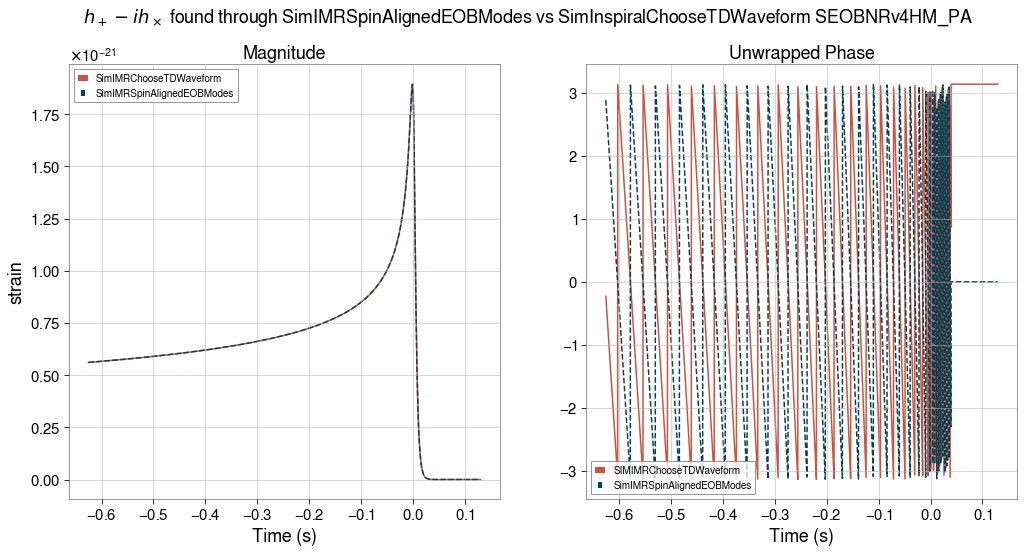

In [ ]:
# In principle we should be able to call the TD waveform and do the sum in the time domain to make sure we get the same thing on both sides

# Getting the WF through SimInspiralChooseTDWaveform
lal_params = waveform_generator.waveform_generator.SEOBNRv4HM_qnm_lal_dict(ref_parameters)
p = wfg._convert_parameters_to_lal_frame(ref_parameters, lal_params, lal_target_function="SimInspiralTD")
delta_t = p[-5]
hp, hc = LS.SimInspiralChooseTDWaveform(*p)
pol_ref = {"h_plus": hp.data.data, "h_cross": hc.data.data}
strain = pol_ref["h_plus"] - 1j*pol_ref["h_cross"]

# Getting the WF through SimIMRSpinAlignedEOBModes 
p, iota = wfg._convert_parameters_to_lal_frame({**parameters, "f_ref": 20},lal_target_function="SimIMRSpinAlignedEOBModes",)
print(p)

# Note this only gives the (l, m) and we need to find the (l, -m) by noting that h_lm = (-1)**l h*_{l-m}
hlm_td, low_samp_dynamics, high_samp_dynamics = LS.SimIMRSpinAlignedEOBModes(*p)
hlm_td = wfg_utils.linked_list_modes_to_dict_modes(hlm_td)

for (ell, m), hlm in hlm_td.items():
    h_plus, h_cross = wfg_utils.correct_for_eob_lal_frame_rotation(hlm.data.data.real, -hlm.data.data.imag)
    hlm_td[(ell, m)].data.data = h_plus - 1j*h_cross

wfg_utils.get_aligned_spin_negative_modes_in_place(hlm_td)
pol_m = wfg_utils.get_polarizations_from_td_modes_m(hlm_td, iota, parameters["phase"])
pol_m = {(l,m):{k:v.data.data for k, v in pol.items()} for (l, m), pol in pol_m.items()}
pol = sum_contributions_m(pol_m)
mode_strain = pol["h_plus"] - 1j*pol["h_cross"]
# What is the phase and why is it an extrinsic parameter?

# mode_strain = np.sum(np.array([v.data.data * lal.SpinWeightedSphericalHarmonic(iota, parameters["phase"], -2, ell, m) for (ell, m), v in hlm_td.items()]), axis=0)
print(f"SimInspiralChooseTDWaveform shape {strain.shape}  vs SimIMRSpinAlignedEOBModes shape {mode_strain.shape}")

times = np.arange(0, strain.shape[0]*delta_t, delta_t) + hp.epoch

fig, axes = plt.subplots(1, 2, figsize=(17, 8))
fig.suptitle(r"$h_+ - i h_\times$ found through SimIMRSpinAlignedEOBModes vs SimInspiralChooseTDWaveform SEOBNRv4HM_PA")

axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("strain")
# Plotting magnitude
axes[0].set_title("Magnitude")
axes[0].plot(times, np.abs(strain), label=r'SimIMRChooseTDWaveform')
axes[0].plot(times, np.abs(mode_strain), linestyle='--', label=r'SimIMRSpinAlignedEOBModes')
axes[0].legend(loc='upper left')

# Plotting phase
# NOTE I'm not actually a 100% sure what that weird offset is past 0.7 seconds, it is exactly pi? But it happens after the waveform is already dead so not 
# doesn't really matter, essentially it is the difference between -0 and 0
axes[1].set_title("Unwrapped Phase")
axes[1].set_xlabel("Time (s)")
axes[1].plot(times, np.angle(strain), label=r'SIMIMRChooseTDWaveform')
axes[1].plot(times, np.angle(mode_strain), linestyle='--', label=r'SimIMRSpinAlignedEOBModes')
axes[1].legend(loc='lower left')

            # LS.SimIMRSpinAlignedEOBModes takes parameters:
            # delta_t, m1SI, m2SI, f_min, distance, spin1z, spin2z, SpinAlignedEOBversion, 
            # lambda2Tidal1, labmda2Tidal2, omega02Tidal1, omega02Tidal2, lambda3Tidal1, 
            # lambda3Tidal2, omega03Tidal1, omega03Tidal2, quadparam1, quadparam2, 
            # domega220, dtau220, domega210, dtau210, domega330, dtau330,
            # domega440, dtau440, domega550, dtau550,
            #  REAL8Vector nqcCoeffsInput, const INT4 nqcFlag, LALDict *PAparams

/data/nihargupte/projects/dingo-devel/tgr_venv/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


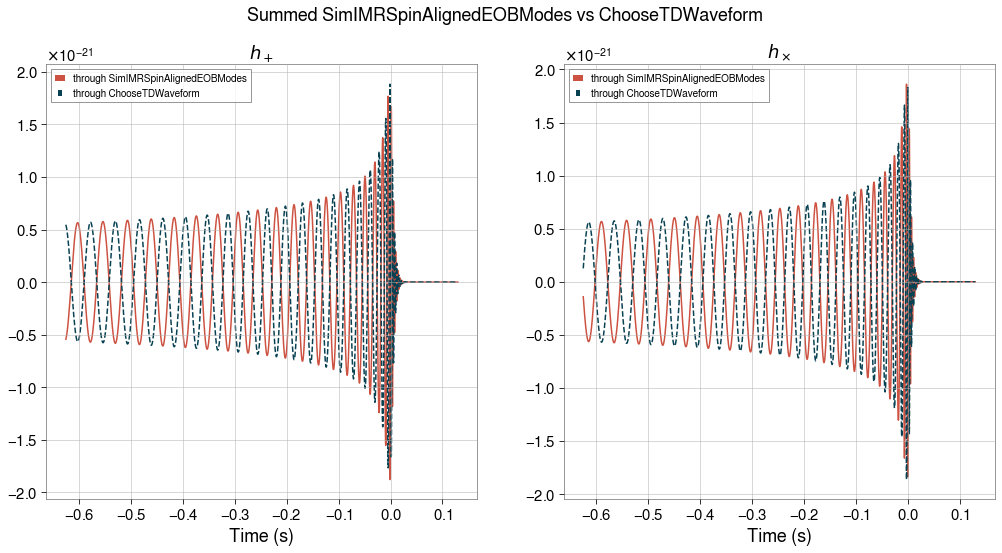

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(17, 8))
fig.suptitle(r"Summed SimIMRSpinAlignedEOBModes vs ChooseTDWaveform")

axes[0].set_title(r"$h_+$")
axes[0].set_xlabel("Time (s)")
axes[0].plot(times, pol["h_plus"], label="through SimIMRSpinAlignedEOBModes")
axes[0].plot(times, pol_ref["h_plus"], linestyle='--', label="through ChooseTDWaveform")
axes[0].legend()

axes[1].set_title(r"$h_\times$")
axes[1].set_xlabel("Time (s)")
axes[1].plot(times, pol["h_cross"], label="through SimIMRSpinAlignedEOBModes")
axes[1].plot(times, pol_ref["h_cross"], linestyle='--', label="through ChooseTDWaveform")
axes[1].legend()

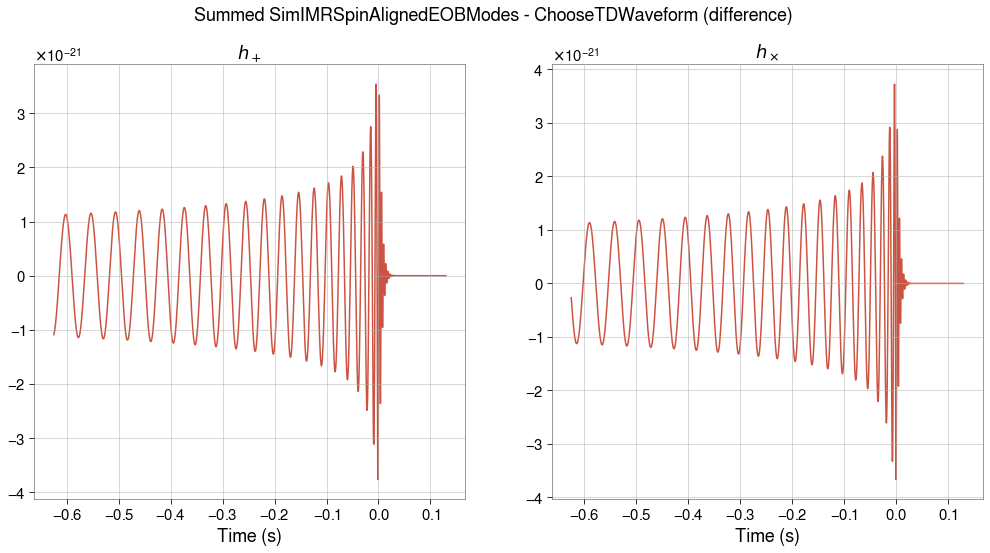

In [ ]:
# Manually check the change the sum then do the FFT stuff to see if it works?
fig, axes = plt.subplots(1, 2, figsize=(17, 8))
fig.suptitle(r"Summed SimIMRSpinAlignedEOBModes - ChooseTDWaveform (difference)")

# axes[0].set_xlim([0, 0.1])
axes[0].set_title(r"$h_+$")
axes[0].set_xlabel("Time (s)")
axes[0].plot(times, pol["h_plus"] - pol_ref["h_plus"])

# axes[1].set_xlim([0, 0.1])
axes[1].set_title(r"$h_\times$")
axes[1].set_xlabel("Time (s)")
axes[1].plot(times, pol["h_cross"] - pol_ref["h_cross"])

Doing Time-Domain Conditioning

Instead of doing ChooseTDWaveform, we eventually want to use SimInspiralFD which calls SimInspiralTD. However, in order to do this, we need to generate the modes at a different f_start. Then apply SimInspiralTDConditionStage1 and SimInspiralTDConditionStage2 to these modes. 

As a first sanity check though, I will sum the modes at that particular fstart and apply the conditioning to the sum to compare directly to lalsiminspiralTD

So now that the mode sum does give the correct result, we need to make sure we do the tapering correctly in the time domain

In [ ]:
# Creating modes at different f_start
parameters_lal, iota = wfg._convert_parameters_to_lal_frame({**parameters, "f_ref": 20},lal_target_function="SimIMRSpinAlignedEOBModes")
parameters_lal = list(parameters_lal)
f_start, extra_time_fraction, t_chirp, t_extra = wfg_utils.get_aligned_spin_f_start(domain.f_min, parameters_lal[1], parameters_lal[2], parameters_lal[5], parameters_lal[6])
parameters_lal[3] = f_start

# Note this only gives the (l, m) and we need to find the (l, -m) by noting that h_lm = (-1)**l h*_{l-m}
hlm_td, low_samp_dynamics, high_samp_dynamics = LS.SimIMRSpinAlignedEOBModes(*parameters_lal)
hlm_td = wfg_utils.linked_list_modes_to_dict_modes(hlm_td)
for (ell, m), hlm in hlm_td.items():
    h_plus, h_cross = wfg_utils.correct_for_eob_lal_frame_rotation(hlm.data.data.real, -hlm.data.data.imag)
    hlm_td[(ell, m)].data.data = h_plus - 1j*h_cross
wfg_utils.get_aligned_spin_negative_modes_in_place(hlm_td)
times = wfg_utils.taper_aligned_spin_td_modes_in_place(hlm_td, parameters_lal[1], parameters_lal[2], extra_time_fraction, t_chirp, t_extra, domain.f_min)

# Technically we don't the rest but we want to make sure we get the same tapering as SimInspiralTD
pol_m = wfg_utils.get_polarizations_from_td_modes_m(hlm_td, iota, parameters["phase"])
pol_m = {(l,m):{k:v.data.data for k, v in pol.items()} for (l, m), pol in pol_m.items()}
pol = sum_contributions_m(pol_m)

-1.211906431 0.0 0.000244140625
-1.211906431 0.0 0.000244140625
-1.211906431 0.0 0.000244140625
-1.211906431 0.0 0.000244140625
-1.211906431 0.0 0.000244140625
-1.211906431 0.0 0.000244140625
-1.211906431 0.0 0.000244140625
-1.211906431 0.0 0.000244140625
-1.211906431 0.0 0.000244140625
-1.211906431 0.0 0.000244140625


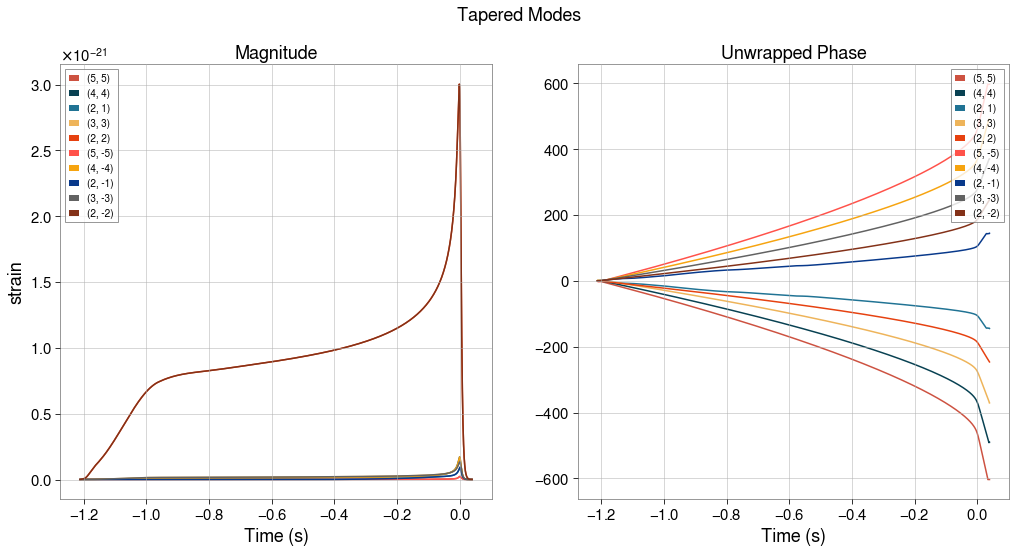

In [ ]:
# Shouldn't the positive frequencies be non-zero not the negative frequencies??
# Converting to frequency domain
fig, axes = plt.subplots(1, 2, figsize=(17, 8))
fig.suptitle("Tapered Modes")

axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("strain")
axes[0].set_title("Magnitude")

for (ell, m), td in hlm_td.items():
    axes[0].plot(times, np.abs(td.data.data), label=f"({ell}, {m})")
    axes[1].plot(times, np.unwrap(np.angle(td.data.data)), label=f"({ell}, {m})")

axes[0].legend()
axes[1].set_title("Unwrapped Phase")
axes[1].set_xlabel("Time (s)")

axes[1].legend(loc='upper right')
# plt.savefig("/data/nihargupte/projects/dingo-devel/tutorials/06_tgr/plots/XLALSimIMRSpinAlignedEOBModes_PA.png")

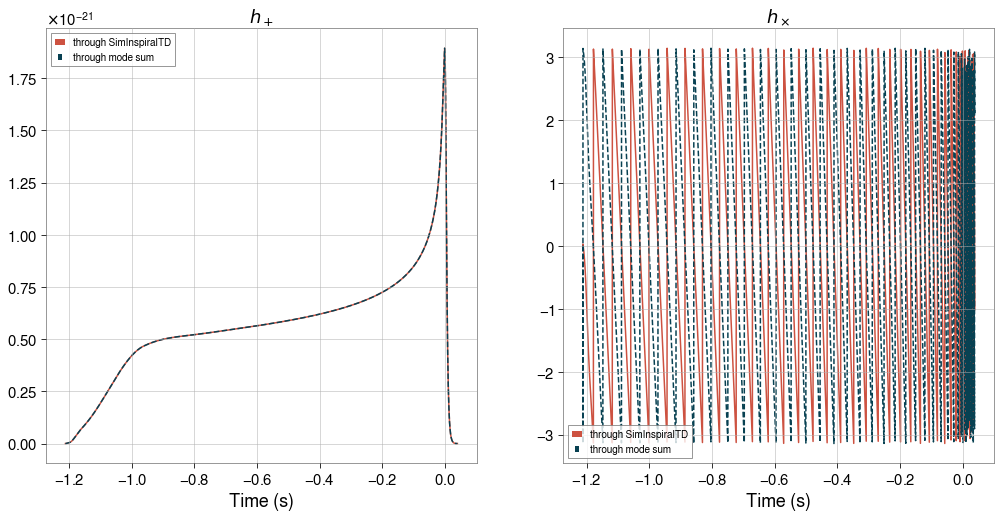

In [ ]:
# SimInspiralTD already does the conditioning
fig, axes = plt.subplots(1, 2, figsize=(17, 8))

p = wfg._convert_parameters_to_lal_frame(ref_parameters, lal_params, lal_target_function="SimInspiralTD")
hp, hc = LS.SimInspiralTD(*p) # Essentially SimInspiralTD but for all models that are not PHM
ref_times = np.arange(0, hp.data.length*hp.deltaT, hp.deltaT) + hp.epoch
pol_ref = {"h_plus": hp.data.data, "h_cross": hc.data.data}
ref_strain = pol_ref["h_plus"] - 1j*pol_ref["h_cross"]

# Summing the modes
mode_strain = pol["h_plus"] - 1j*pol["h_cross"]

axes[0].set_title(r"$h_+$")
axes[0].set_xlabel("Time (s)")
axes[0].plot(ref_times, np.abs(ref_strain), label="through SimInspiralTD")
axes[0].plot(times, np.abs(mode_strain), linestyle='--', label="through mode sum")
axes[0].legend()

axes[1].set_title(r"$h_\times$")
axes[1].set_xlabel("Time (s)")
axes[1].plot(ref_times, np.angle(ref_strain), label="through SimInspiralTD")
axes[1].plot(times, np.angle(mode_strain), linestyle='--', label="through mode sum")
axes[1].legend()

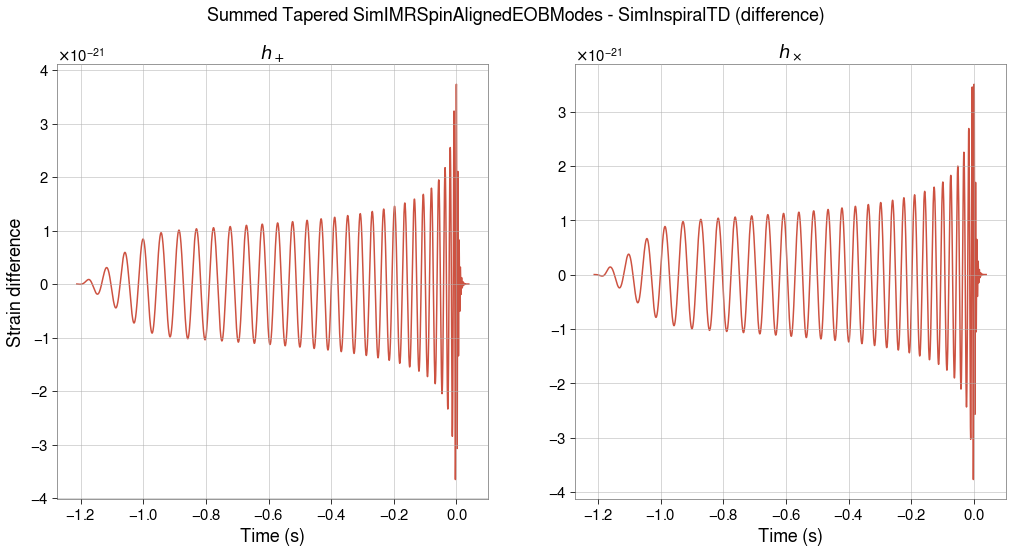

In [ ]:
# Manually check the change the sum then do the FFT stuff to see if it works?
fig, axes = plt.subplots(1, 2, figsize=(17, 8))
fig.suptitle(r"Summed Tapered SimIMRSpinAlignedEOBModes - SimInspiralTD (difference)")

# axes[0].set_xlim([0, 0.1])
axes[0].set_ylabel("Strain difference")
axes[0].set_title(r"$h_+$")
axes[0].set_xlabel("Time (s)")
axes[0].plot(times, pol["h_plus"] - pol_ref["h_plus"])

# axes[1].set_xlim([0, 0.1])
axes[1].set_title(r"$h_\times$")
axes[1].set_xlabel("Time (s)")
axes[1].plot(times, pol["h_cross"] - pol_ref["h_cross"])

Ok Now that SimInpsiralTD (includes tapering) is working we need to FFT the modes individually and resum in the Fourier Domain

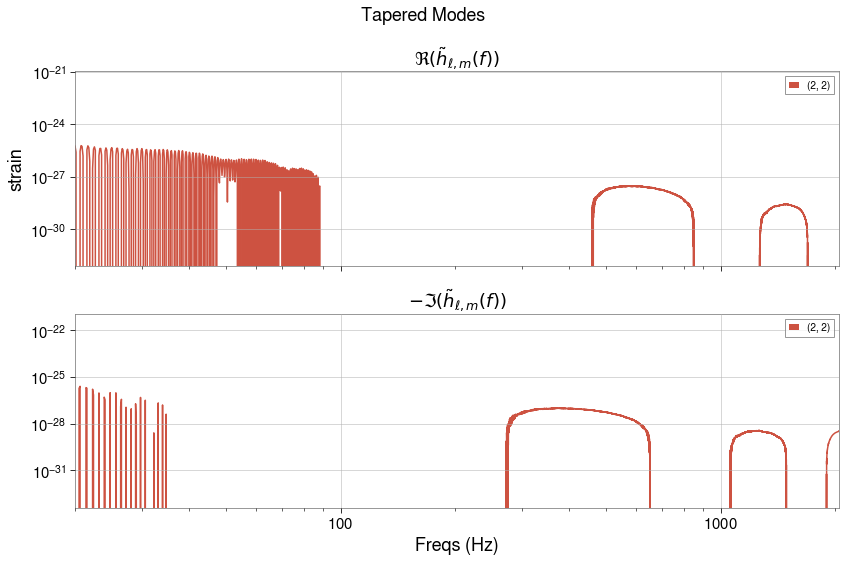

In [ ]:
freqs = np.concatenate((-domain()[::-1], domain()[1:]), axis=0)
hlm_fd = wfg_utils.td_modes_to_fd_modes(hlm_td, domain)

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
fig.suptitle("Tapered Modes")

axes[0].set_xlim([20, 2048])
axes[0].set_yscale('log')
axes[0].set_xscale('log')
axes[0].set_ylabel("strain")
axes[0].set_title(r"$\Re (\tilde h_{\ell, m} (f))$")

for (ell, m), fd in hlm_fd.items():
    if (ell, m) == (2, 2):
        axes[0].plot(freqs, fd.real, label=f"({ell}, {m})")
        axes[1].plot(freqs, -fd.imag, label=f"({ell}, {m})")

axes[0].legend()
axes[1].set_xlim([20, 2048])
axes[1].set_yscale('log')
axes[1].set_xscale('log')
axes[1].set_xlabel("Freqs (Hz)")
axes[1].set_title(r"$-\Im (\tilde h_{\ell, m} (f))$")

axes[1].legend(loc='upper right')
plt.tight_layout()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


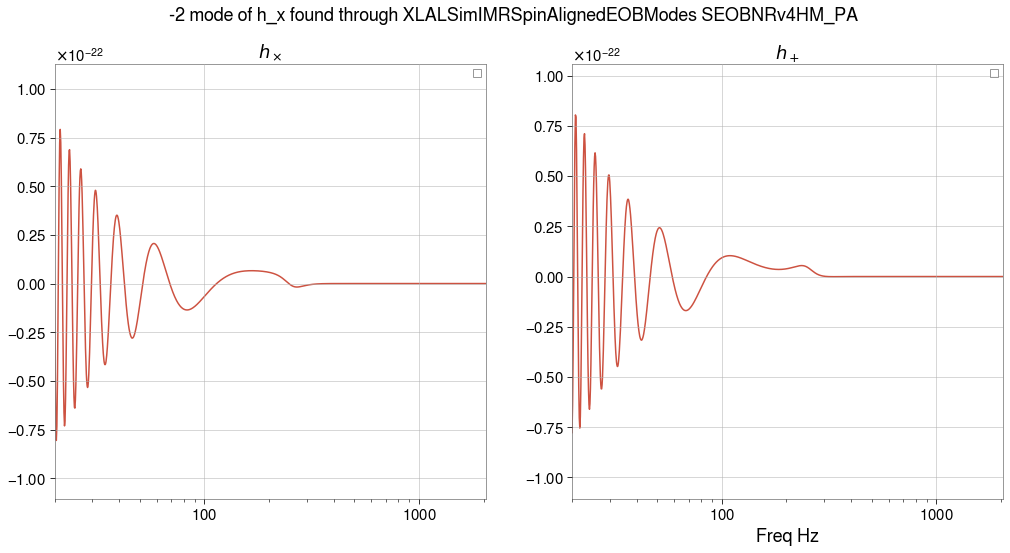

In [ ]:
pol_m = wfg_utils.get_polarizations_from_fd_modes_m(hlm_fd, iota, parameters["phase"])
fig, axes = plt.subplots(1, 2, figsize=(17, 8))
m = -2
fig.suptitle(f"{m} mode of h_x found through XLALSimIMRSpinAlignedEOBModes SEOBNRv4HM_PA")

axes[0].set_xscale('log')
axes[0].set_xlim([20, 2048])
axes[0].set_title(r"$h_\times$")
axes[0].plot(domain.sample_frequencies, pol_m[m]["h_cross"])
axes[0].legend()

# Plotting phase
axes[1].set_xscale('log')
axes[1].set_xlim([20, 2048])
axes[1].set_title(r"$h_+$")
axes[1].set_xlabel("Freq Hz")
axes[1].plot(domain.sample_frequencies, pol_m[m]["h_plus"])
axes[1].legend(loc='upper right')
# plt.savefig("/data/nihargupte/projects/dingo-devel/tutorials/06_tgr/plots/XLALSimIMRSpinAlignedEOBModes_PA_pol.png")

(7.734914519351992e+31, 6.3430275878490625e+31, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.3576981358562016e+25, 0.0, 4.7, 0.0, 0.0, 0.0, 0.125, 20.0, 2048.0, 20.0, <Swig Object of type 'tagLALDict *' at 0x7fac92eed230>, 95)
(-9.574180998490309e-26+0j)


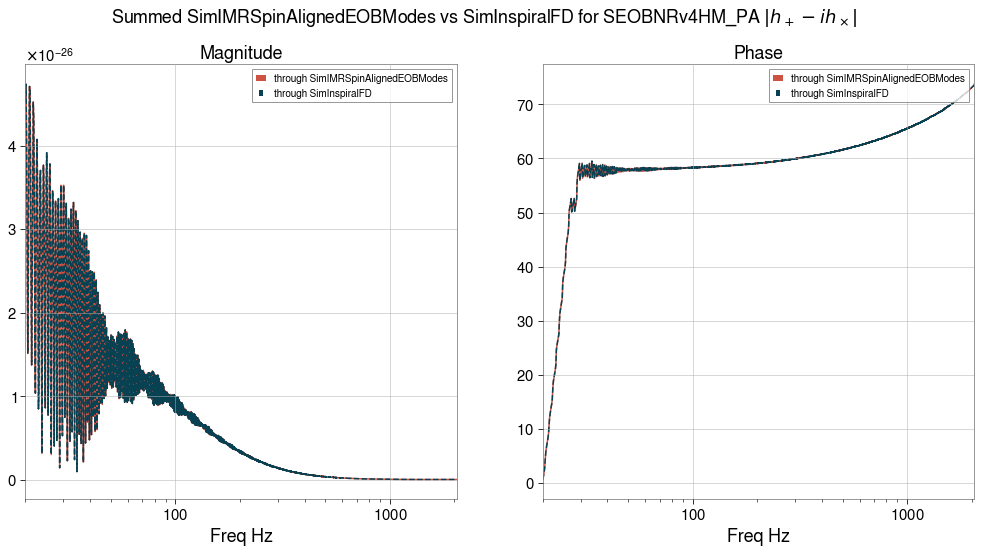

In [ ]:
pol = sum_contributions_m(pol_m, phase_shift=phase_shift)
pol_ref = wfg.generate_hplus_hcross(ref_parameters)

ref_strain = pol_ref["h_plus"] - 1j*pol_ref["h_cross"]
strain = pol["h_plus"] - 1j*pol["h_cross"]

fig, axes = plt.subplots(1, 2, figsize=(17, 8))
fig.suptitle(r"Summed SimIMRSpinAlignedEOBModes vs SimInspiralFD for SEOBNRv4HM_PA $|h_+ - i h_\times|$")

axes[0].set_xscale('log')
f_min_idx = np.argmin(np.abs(domain.sample_frequencies - 20))
axes[0].set_xlim([20, 2048])
axes[0].set_title("Magnitude")
axes[0].set_xlabel("Freq Hz")
axes[0].plot(domain.sample_frequencies[f_min_idx:], np.abs(strain[f_min_idx:]), label="through SimIMRSpinAlignedEOBModes")
axes[0].plot(domain.sample_frequencies[f_min_idx:], np.abs(ref_strain[f_min_idx:]), linestyle='--', label="through SimInspiralFD")
axes[0].legend()

# Plotting phase
axes[1].set_xscale('log')
axes[1].set_xlim([20, 2048])
axes[1].set_title("Phase")
axes[1].set_xlabel("Freq Hz")
axes[1].plot(domain.sample_frequencies[f_min_idx:], np.unwrap(np.angle(strain[f_min_idx:])), label="through SimIMRSpinAlignedEOBModes")
axes[1].plot(domain.sample_frequencies[f_min_idx:], np.unwrap(np.angle(ref_strain[f_min_idx:])), linestyle='--', label="through SimInspiralFD")
axes[1].legend(loc='upper right')
# plt.savefig("/data/nihargupte/projects/dingo-devel/tutorials/06_tgr/plots/XLALSimIMRSpinAlignedEOBModes_PA_summed_comp.png")

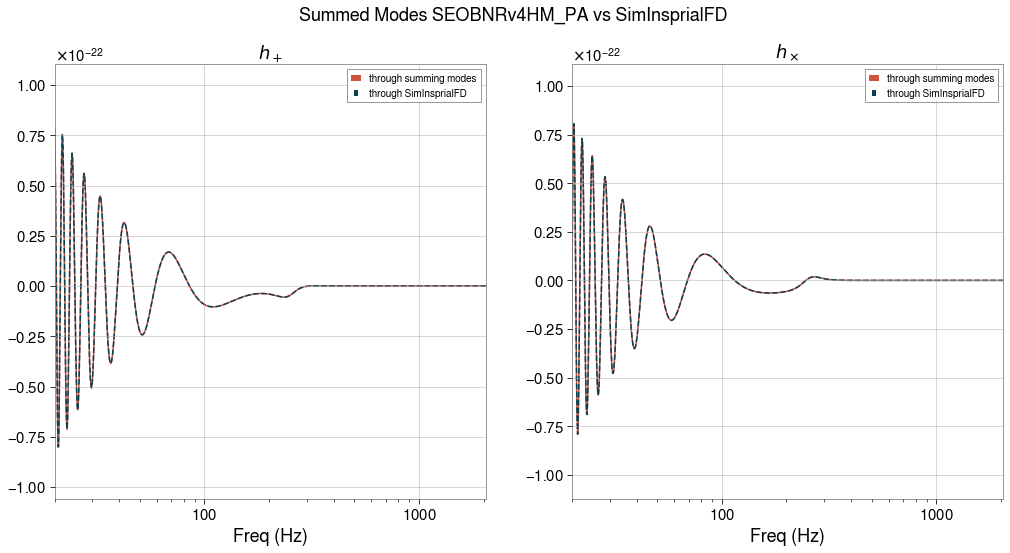

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(17, 8))
fig.suptitle(r"Summed Modes SEOBNRv4HM_PA vs SimInsprialFD")

axes[0].set_xscale('log')
axes[0].set_xlim([20, 2048])
axes[0].set_title(r"$h_+$")
axes[0].set_xlabel("Freq (Hz)")
axes[0].plot(domain.sample_frequencies, pol["h_plus"], label="through summing modes")
axes[0].plot(domain.sample_frequencies, pol_ref["h_plus"], linestyle='--', label="through SimInsprialFD")
axes[0].legend()

axes[1].set_xscale('log')
axes[1].set_xlim([20, 2048])
axes[1].set_title(r"$h_\times$")
axes[1].set_xlabel("Freq (Hz)")
axes[1].plot(domain.sample_frequencies, pol["h_cross"], label="through summing modes")
axes[1].plot(domain.sample_frequencies, pol_ref["h_cross"], linestyle='--', label="through SimInsprialFD")
axes[1].legend()

In [ ]:
from dingo.gw.gwutils import get_mismatch
mismatches = [get_mismatch(pol[pol_name], pol_ref[pol_name], wfg.domain) for pol_name in pol]
print(mismatches)

[0.0, 0.0]


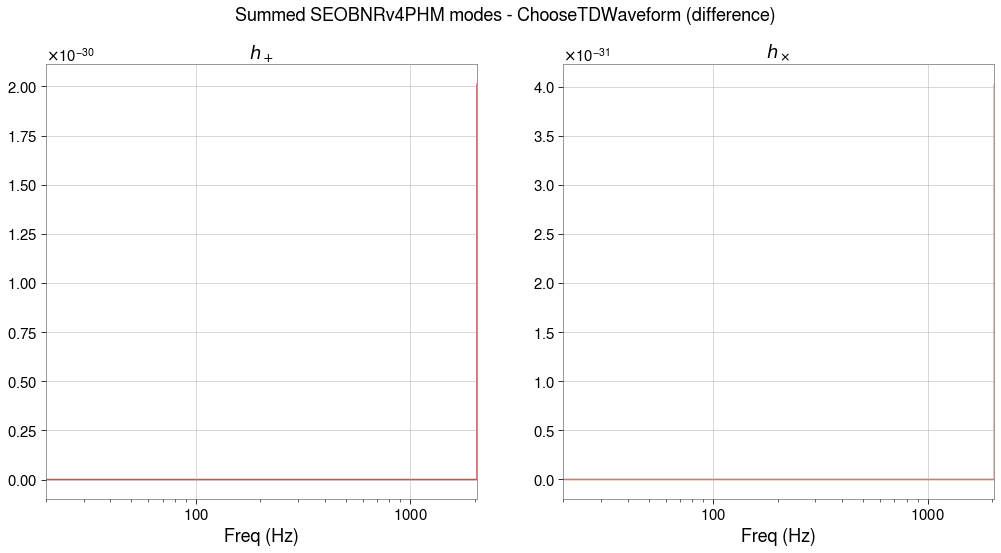

In [ ]:
# Manually check the change the sum then do the FFT stuff to see if it works?
fig, axes = plt.subplots(1, 2, figsize=(17, 8))
fig.suptitle(r"Summed SEOBNRv4PHM modes - ChooseTDWaveform (difference)")

axes[0].set_xlim([20, 2048])
axes[0].set_title(r"$h_+$")
axes[0].set_xscale('log')
axes[0].set_xlabel("Freq (Hz)")
axes[0].plot(domain.sample_frequencies, pol["h_plus"] - pol_ref["h_plus"])

axes[1].set_xlim([20, 2048])
axes[1].set_xscale('log')
axes[1].set_title(r"$h_\times$")
axes[1].set_xlabel("Freq (Hz)")
axes[1].plot(domain.sample_frequencies, pol["h_cross"] - pol_ref["h_cross"])

Testing Dingo API

Setting spin_conversion_phase = 0.0. Using this value for the phase parameter for conversion to cartesian spins.
(7.734914519351992e+31, 6.3430275878490625e+31, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.3576981358562016e+25, 0.0, 4.7, 0.0, 0.0, 0.0, 0.125, 20.0, 2048.0, 20.0, <Swig Object of type 'tagLALDict *' at 0x7fac979c68f0>, 95)
(-9.574180998490309e-26+0j)


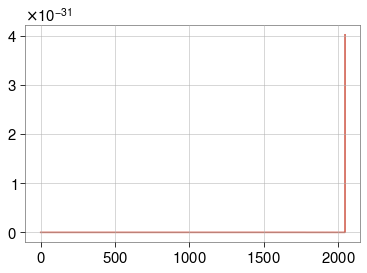

In [ ]:
wfg = WaveformGenerator(
    "SEOBNRv4HM_PA",
    domain,
    20.0,
    spin_conversion_phase=0.0,
)

pol_ref = wfg.generate_hplus_hcross(ref_parameters)
pol_m = wfg.generate_hplus_hcross_m(parameters)
pol = sum_contributions_m(pol_m, phase_shift=phase_shift)

plt.plot(domain.sample_frequencies, pol["h_cross"] - pol_ref["h_cross"])


Weird Disagreement between Aligned Spin...

0.125 16385
0.125 16385


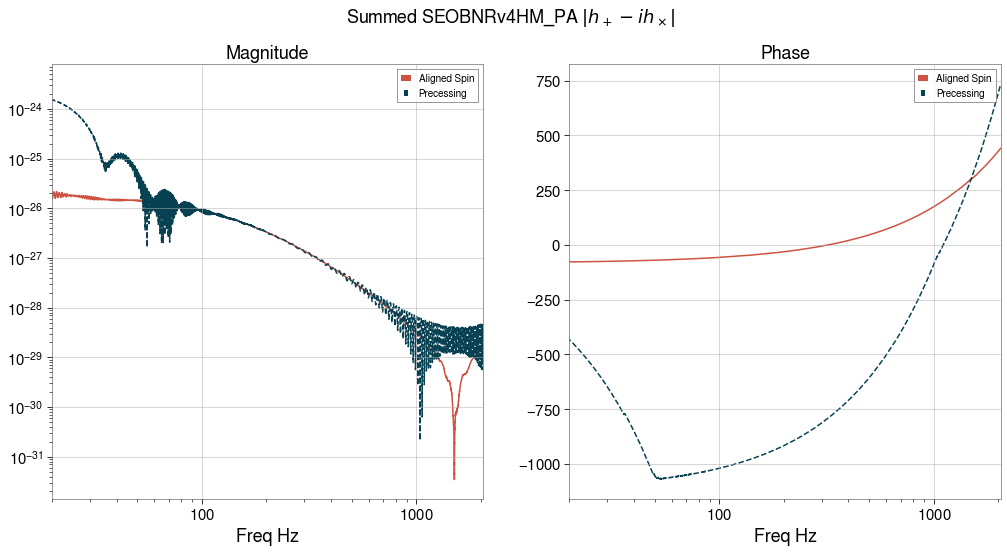

In [ ]:
#   m1, m2, S1x, S1y, S1z, S2x, S2y, S2z,
#   distance, inclination, phiRef,
#   longAscNodes, eccentricity, meanPerAno,
#   deltaF, f_min, f_max, f_ref,
#   lal_params, approximant
p = [7.734914519351992e+31, 6.3430275878490625e+31, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.3576981358562016e+25, 0, 0.0, 0.0, 0.0, 0.0, 0.125, 10.0, 2048.0, 20.0, None, LS.SEOBNRv4PHM]
phm_hp, phm_hc = LS.SimInspiralFD(*p)
# np.arange()
print(phm_hp.deltaF, phm_hp.data.length)
phm_hp = phm_hp.data.data
phm_hc = phm_hc.data.data
ref_strain = phm_hp - 1j*phm_hc
p[-1] = LS.SEOBNRv4HM
hm_hp, hm_hc = LS.SimInspiralFD(*p)
print(hm_hp.deltaF, hm_hp.data.length)
hm_hp = hm_hp.data.data
hm_hc = hm_hc.data.data
strain = hm_hp - 1j*hm_hc

fig, axes = plt.subplots(1, 2, figsize=(17, 8))
fig.suptitle(r"Summed SEOBNRv4HM_PA $|h_+ - i h_\times|$")

axes[0].set_xscale('log')
axes[0].set_xlim([20, 2048])
axes[0].set_yscale('log')
axes[0].set_title("Magnitude")
axes[0].set_xlabel("Freq Hz")
axes[0].plot(domain.sample_frequencies, np.abs(strain), label="Aligned Spin")
axes[0].plot(domain.sample_frequencies, np.abs(ref_strain), linestyle='--', label="Precessing")
axes[0].legend()

# Plotting phase
axes[1].set_xscale('log')
axes[1].set_xlim([20, 2048])
axes[1].set_title("Phase")
axes[1].set_xlabel("Freq Hz")
axes[1].plot(domain.sample_frequencies, np.unwrap(np.angle(strain)), label="Aligned Spin")
axes[1].plot(domain.sample_frequencies, np.unwrap(np.angle(ref_strain)), linestyle='--', label="Precessing")
axes[1].legend(loc='upper right')


Downloading GW150914 Data and Using it to test our pre-post SNR script is working
---------------------------------------------------------------------------------

In [ ]:
# Download data for GW150914
trigger_time = 1126259462.391

roll_off = 0.4  # Roll off duration of tukey window in seconds, default is 0.4s
duration = 8  # Analysis segment duration
post_trigger_duration = 2  # Time between trigger time and end of segment
end_time = trigger_time + post_trigger_duration
start_time = end_time - duration

psd_duration = 1024
psd_start_time = start_time - psd_duration
psd_end_time = start_time

# We now use gwpy to obtain analysis and psd data and create the ifo_list
ifo_list = bilby.gw.detector.InterferometerList(["H1", "L1"])
for det in ["H1", "L1"]:
    ifo = bilby.gw.detector.get_empty_interferometer(det)
    ifo.strain_data.roll_off = 0.4  # Set this explicitly. Default is 0.2.
    data = TimeSeries.fetch_open_data(det, start_time, end_time, cache=True)
    ifo.strain_data.set_from_gwpy_timeseries(data)

    psd_data = TimeSeries.fetch_open_data(det, psd_start_time, psd_end_time,
                                          cache=True)
    psd_alpha = 2 * roll_off / duration

    # Use pycbc psd routine
    sampling_rate = len(psd_data)/psd_duration
    psd_data_pycbc = psd_data.to_pycbc()
    w = tukey(int(duration * sampling_rate), psd_alpha)
    psd = pycbc.psd.estimate.welch(psd_data_pycbc,
                                   seg_len=int(duration * sampling_rate),
                                   seg_stride=int(duration * sampling_rate),
                                   window=w,
                                   avg_method='median')
    ifo.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
        frequency_array=np.array(psd.sample_frequencies),
        psd_array=np.array(psd))


In [ ]:
# Code to return SNR in pre and post inspiral region, validated on GW150914

def get_snr(sample_frequencies, asd, signal, duration = 8.0, window_factor=1.0):
    integrand = (np.conj(signal) * signal) / ((asd ** 2) * window_factor)
    snr = ((4 / duration) * np.sum(integrand)) ** 0.5
    return snr

def get_f_isco(pe_parameters):
    m1, m2, chi1, chi2 = pe_parameters["mass_1"], pe_parameters["mass_2"], pe_parameters["chi_1"], pe_parameters["chi_2"]
    a_f = nrutils.bbh_final_spin_non_precessing_Healyetal(m1, m2, chi1, chi2, version="2016")
    M = nrutils.bbh_final_mass_non_precessing_Healyetal(m1, m2, chi1, chi2, version="2016")
    r_isco_tilde = nrutils.calc_isco_radius(a_f)
    omega_tilde = 1 / (r_isco_tilde**(3/2) + a_f)
    M_SI = M * lal.MSUN_SI
    f_isco = omega_tilde / (np.pi * (M_SI*(lal.G_SI/(lal.C_SI**3))))
    return f_isco

def get_snr_pre_post_inspiral(sample_frequencies, asd, signal, pe_parameters):
    f_isco = get_f_isco(pe_parameters)
    f_idx_isco = np.argmin(np.abs(sample_frequencies - f_isco))
    pre_inspiral_snr = get_snr(sample_frequencies[:f_idx_isco], asd[:f_idx_isco], signal[:f_idx_isco])
    post_inspiral_snr = get_snr(sample_frequencies[f_idx_isco:], asd[f_idx_isco:], signal[f_idx_isco:])
    return pre_inspiral_snr, post_inspiral_snr
    

# A bit tricky because what is meant by pre and post inspiral we have the f_isco frequency but don't we actually need the t_isco and then the asd_isco and fft the TD signal?
# that would make more sense to me? If it's monotonically increasing tho....
for ifo in ifo_list:
    pre_inspiral_snr, post_inspiral_snr = get_snr_pre_post_inspiral(ifo.frequency_array, ifo.power_spectral_density.asd, ifo.signal)
print(psd)

ValueError: Can not calculate a frequency series without a legitimate sampling_frequency (None) or duration (None)

In [ ]:
# import ctypes
# lalsim = ctypes.CDLL('/home/local/nihargupte/tgr/src/lalsuite/lalsimulation/lib/LALSimInspiralEOBPAAuxiliaryFuncs.o')
# maybe use ctypes later??


def sim_inspiral_eob_post_adiabatic_total_spin(q, a1, a2):
    invQ = 1. / q
    onePlusInvQ = 1. + invQ

    aTotal = (a1 + a2*invQ*invQ) / (onePlusInvQ * onePlusInvQ)
    return aTotal

def sim_radius_kerr_isco(a):
    z1 = 1. + pow(1. - a * a, 1. / 3.) * (pow(1. + a, 1. / 3.) + pow(1. - a, 1. / 3.))
    z2 = np.sqrt(3. * a * a + z1 * z1)
    return 3. + z2 - (-1 if a < 0 else 1) * np.sqrt((3. - z1) * (3. + z1 + 2. * z2))

def eob_post_adiabatic_final_radius(q, a1, a2): 
    aTotal = sim_inspiral_eob_post_adiabatic_total_spin(q, a1, a2)
    rISCO = sim_radius_kerr_isco(aTotal)
    finalRadiusPrefactor = 1.0

    rFinal = finalRadiusPrefactor * rISCO
    return rFinal

parameters["mass_ratio"] = parameters["mass_2"] / parameters["mass_1"]
final_radius = eob_post_adiabatic_final_radius(1 / parameters["mass_ratio"], parameters["chi_1"], parameters["chi_2"])
print(final_radius)
# Computing ISCO radius using Deyan's code
# pprint(dir(LS))
# LS.SimInspiralEOBPostAdiabaticFinalRadius(parameters["mass_ratio"], parameters["chi_1"] * parameters["mass_1"], parameters["chi_2"] * parameters["mass_2"])


3.39673097215285


In [ ]:
# # Need to find where the cutoff frequency is, this is the frequency of the ISCO corresponding to the remnant Kerr BH
# # Using [1] arXiv:0801.4297

# def f_isco(chi_1, chi_2, mass_ratio):
#     pass 

# def Z_1(a_f, M):
#     A = 1 + ((1 - (a_f/M)**2) ** (1/3))
#     B = ((1 + (a_f/M)) ** (1/3)) + ((1 - (a_f/M)) ** (1/3))
#     print(A)
#     return A * B

# def Z_2(a_f, M):
#     Z1 = Z_1(a_f, M)
#     return (3 * ((a_f/M) ** 2) + (Z_1(a_f, M) ** 2)) ** (1/2)

# # prograde orbit
# def r_isco(a_f, M):
#     Z1 = Z_1(a_f, M)
#     Z2 = Z_2(a_f, M)
#     return M * (3 + Z2 - (((3 - Z1) * (3 + Z1 + 2*Z2)) ** (1/2)))

# # prograde orbit
# def L_orb(a_f, q, M):
#     r = r_isco(a_f, M)
#     num = r**2 - (2 * a_f * M**(1/2) * r**(1/2)) + a_f**2
#     denom = M**(1/2) * r**(3/4) * ((r**(3/2) - 3*M*(r**(1/2)) + 2*a_f*(M**(1/2))) ** (1/2))
#     return (q / ((1 + q) ** 2)) * (num / denom)

# # prograde orbit
# def f_isco(a_f, M):
#     r = r_isco(a_f, M)
#     return (1 / np.pi) * (M ** (1/2)) / ((r ** (3/2)) + (a_f * M **(1/2)))

# M = 50
# a_f = np.linspace(0.1, 0.99, 100)
# plt.plot(a_f, f_isco(a_f, M))
# # def a_f(chi_1, chi_2, q):
# #     LORB = L_orb(a_f)
